 **Project: Using NLP for Requirements Engineering for Data management Software**
 
Azure Data Factory 2Query: Fine tuning the data set


**Query**

SELECT
    q.Id AS QuestionId,
    q.Title AS QuestionTitle,
    q.Body AS QuestionBody,
    q.Tags AS QuestionTags,
    q.CreationDate AS Date,
    q.ViewCount AS ViewCount,
    q.Score AS Score,
    q.AnswerCount AS NumberOfAnswers,
    a.Id AS AnswerId,
    a.Body AS AnswerBody
FROM 
    Posts q
INNER JOIN 
    Posts a ON a.ParentId = q.Id
WHERE 
    q.PostTypeId = 1
    AND (
        q.Tags LIKE '%<azure-data-factory>%'
        OR q.Tags LIKE '%<adf>%'
        OR q.Title Like '%<azure data factory>%'
        OR q.Title Like '%<adf>%'
    )
    AND q.CreationDate >= '2018-01-01'
    AND q.CreationDate <= '2023-05-03'
ORDER BY 
    q.CreationDate DESC 

**Tags**

azure-data-factory

adf

**Title** 

azure data factory

adf

In [1]:
#!pip install ipython
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.rendered_html { max-height: 500px; overflow-y: scroll !important; }</style>"))

In [2]:
import pandas as pd

# Load the datasets into pandas DataFrames
df = pd.read_csv('adf_query_lemmatized.csv')

In [3]:
len(df)

8547

tags: pipeline, dataflow

title: mapping, data flow, data flow, flow, pipeline

text: dataflow, data flow, flow, pipeline, following, mapping

In [6]:
import datetime
# Convert the 'Date' column to a datetime object to allow for better manipulation:
df['Date'] = pd.to_datetime(df['Date'])

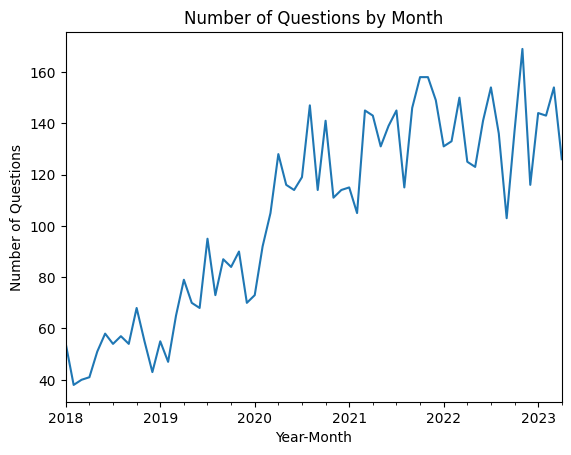

In [7]:
import matplotlib.pyplot as plt
# Analyze the distribution of questions over time:

df['YearMonth'] = df['Date'].dt.to_period('M')

question_count_by_month = df.groupby('YearMonth')['QuestionId'].nunique()
question_count_by_month.plot()
plt.xlabel('Year-Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions by Month')
plt.show()

In [8]:
# Create a sub-set of data which excludes rows where the creation date is before February 2020. 
# The graph above shows a drastic increase of questions regarding Azure Data Factory around the 
# beginning of the corona virus pandemic in February 2020.

# Create new column CreationDate to allow filtering
df['CreationDate'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2020-02-01')

# Filter by relevant keywords identified in previous queries
title_keywords = ['mapping', 'data flow', 'dataflow', 'flow', 'pipeline']
body_keywords = ['dataflow', 'data flow', 'flow', 'pipeline', 'following', 'mapping']
tags_keywords = ['pipeline', 'dataflow']

# Create new data frame with date and keyword filters
create_new_df = df[((df['QuestionTitle'].str.contains('|'.join(title_keywords), case=False)) |
                 (df['QuestionBody'].str.contains('|'.join(body_keywords), case=False)) |
                 (df['QuestionTags'].str.contains('|'.join(tags_keywords), case=False))) &
                 (df['CreationDate'] >= start_date)]

In [9]:
len(create_new_df)

4035

In [10]:
df2 = create_new_df.copy()

In [11]:
# Check if data filter was applied correctly

if df2[df2['CreationDate'] < '2020-02-01'].shape[0] > 0:
    print("There are rows in df2 with CreationDate earlier than 2020-02-01")
else:
    print("All rows in df2 have CreationDate after or equal to 2020-02-01")

All rows in df2 have CreationDate after or equal to 2020-02-01


**Initial Data Exploration**

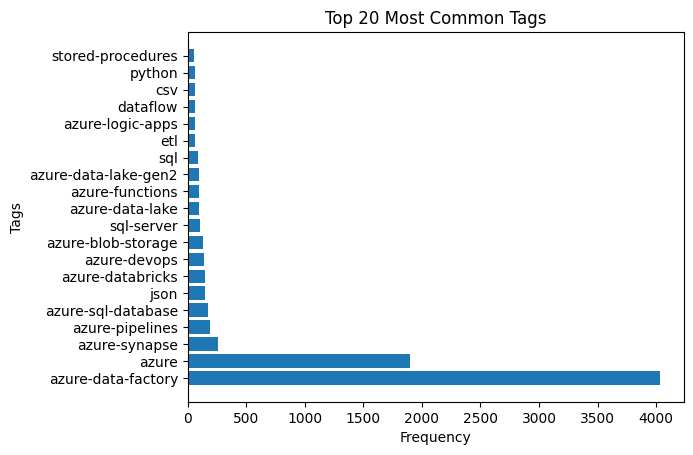

In [12]:
# Analyze the most common tags:
from collections import Counter

import seaborn as sns
tags = df2['QuestionTags'].str.findall('<(.*?)>').explode().values
tag_counts = Counter(tags)
most_common_tags = tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_tags], [count for _, count in most_common_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Tags')
plt.show()

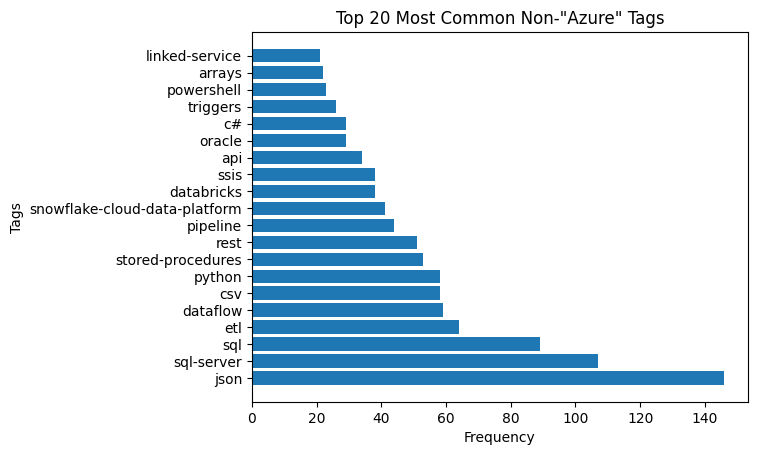

In [13]:
# Analyze the moct common tags which to don contain the keyword "Azure"

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 20 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Non-"Azure" Tags')
plt.show()

#This code filters out empty tags as well as tags containing "azure". 

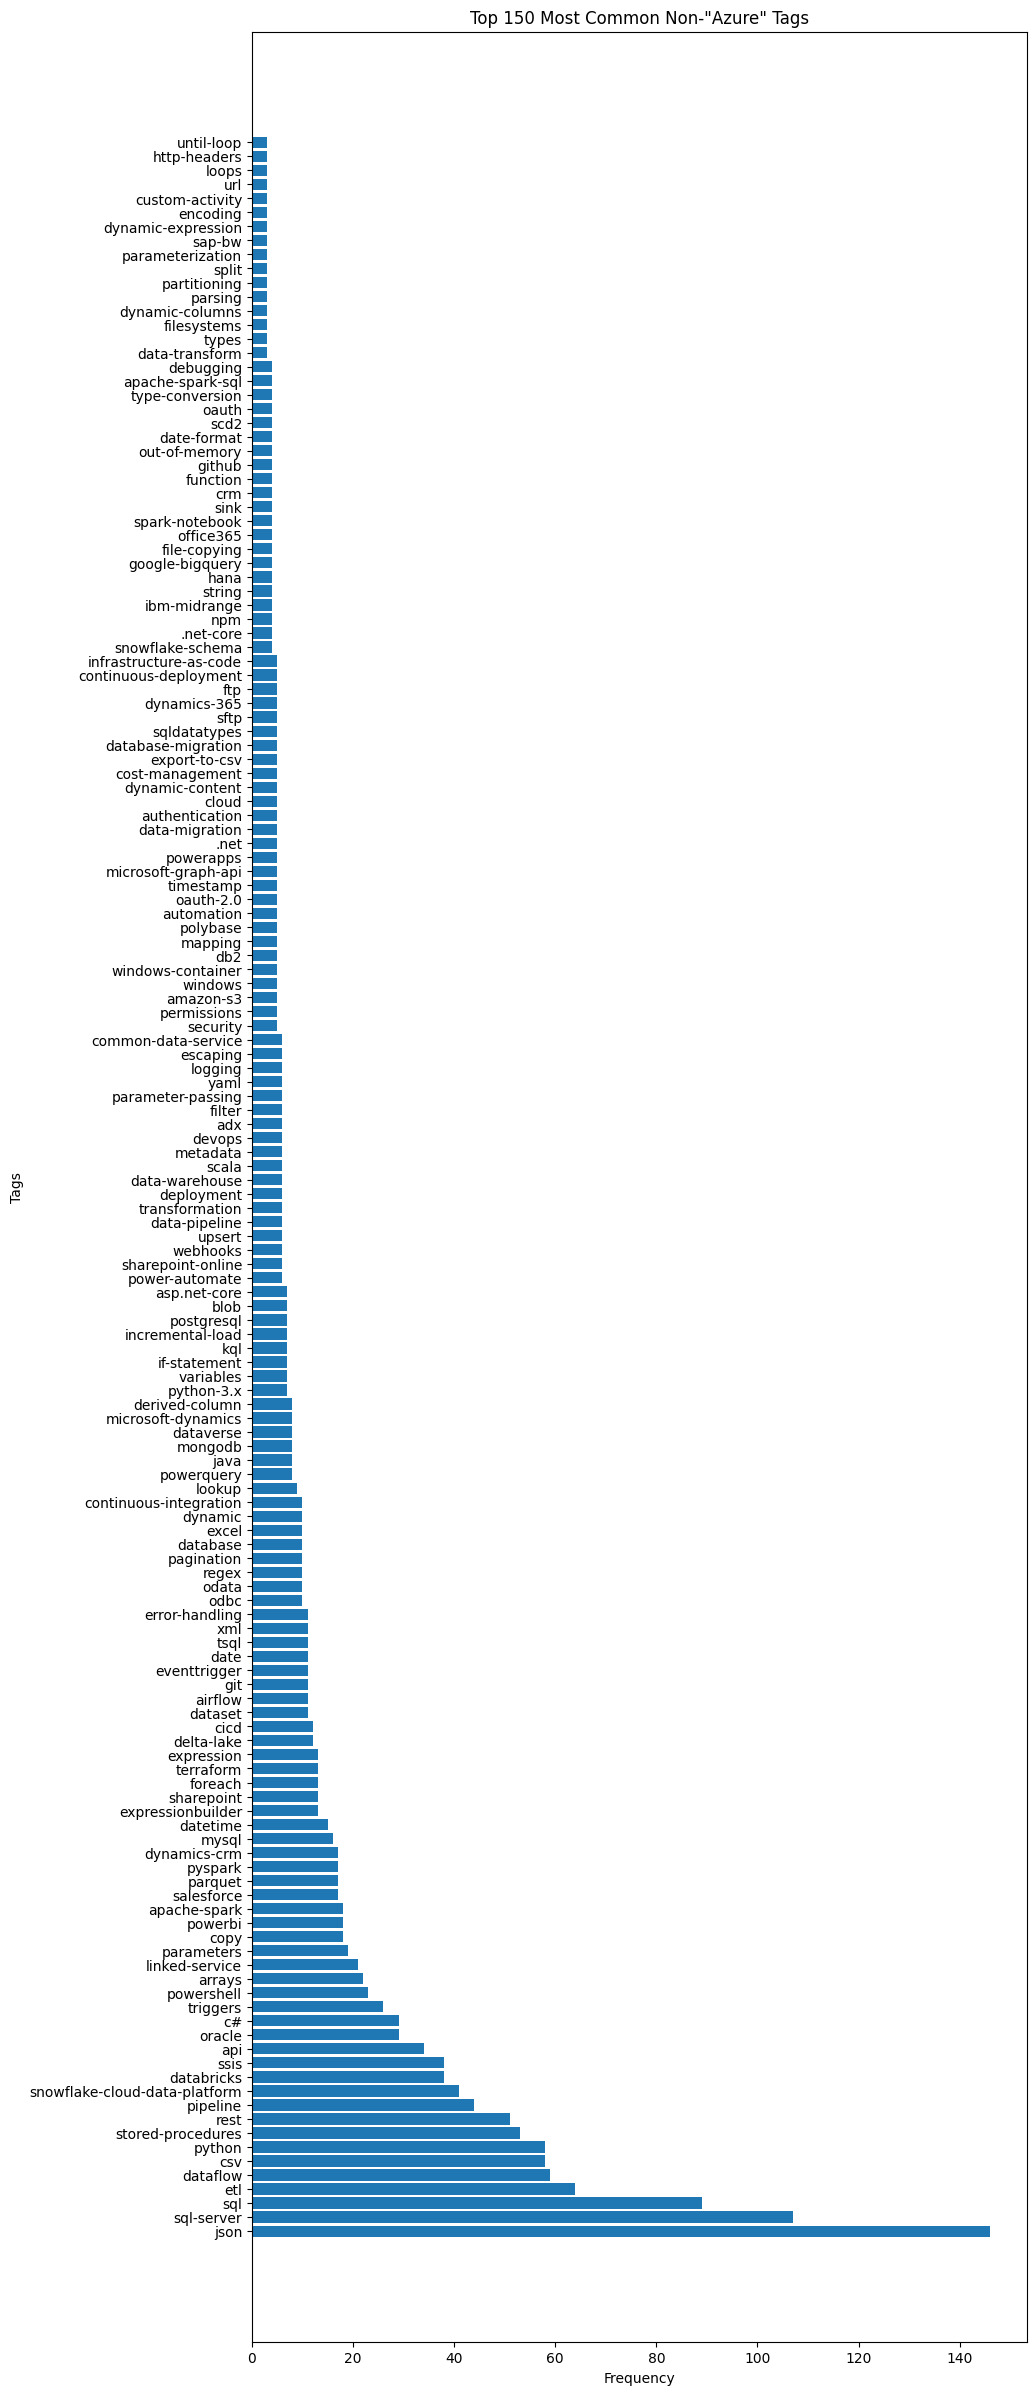

List of the top 150 non-'Azure' tags:
['json', 'sql-server', 'sql', 'etl', 'dataflow', 'csv', 'python', 'stored-procedures', 'rest', 'pipeline', 'snowflake-cloud-data-platform', 'databricks', 'ssis', 'api', 'oracle', 'c#', 'triggers', 'powershell', 'arrays', 'linked-service', 'parameters', 'copy', 'powerbi', 'apache-spark', 'salesforce', 'parquet', 'pyspark', 'dynamics-crm', 'mysql', 'datetime', 'expressionbuilder', 'sharepoint', 'foreach', 'terraform', 'expression', 'delta-lake', 'cicd', 'dataset', 'airflow', 'git', 'eventtrigger', 'date', 'tsql', 'xml', 'error-handling', 'odbc', 'odata', 'regex', 'pagination', 'database', 'excel', 'dynamic', 'continuous-integration', 'lookup', 'powerquery', 'java', 'mongodb', 'dataverse', 'microsoft-dynamics', 'derived-column', 'python-3.x', 'variables', 'if-statement', 'kql', 'incremental-load', 'postgresql', 'blob', 'asp.net-core', 'power-automate', 'sharepoint-online', 'webhooks', 'upsert', 'data-pipeline', 'transformation', 'deployment', 'data-wa

In [14]:
# Show the Top 150 non-Azure keywords

# Find and extract tags
df2['SplitTags'] = df2['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df2.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 150 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(150)

plt.figure(figsize=(10, 30))  # Adjust the plot size for better visibility
plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 150 Most Common Non-"Azure" Tags')
plt.show()

# Print the list of the top 150 non-"azure" tags
top_150_tags = [tag for tag, _ in most_common_non_azure_tags]
print("List of the top 150 non-'Azure' tags:")
print(top_150_tags)

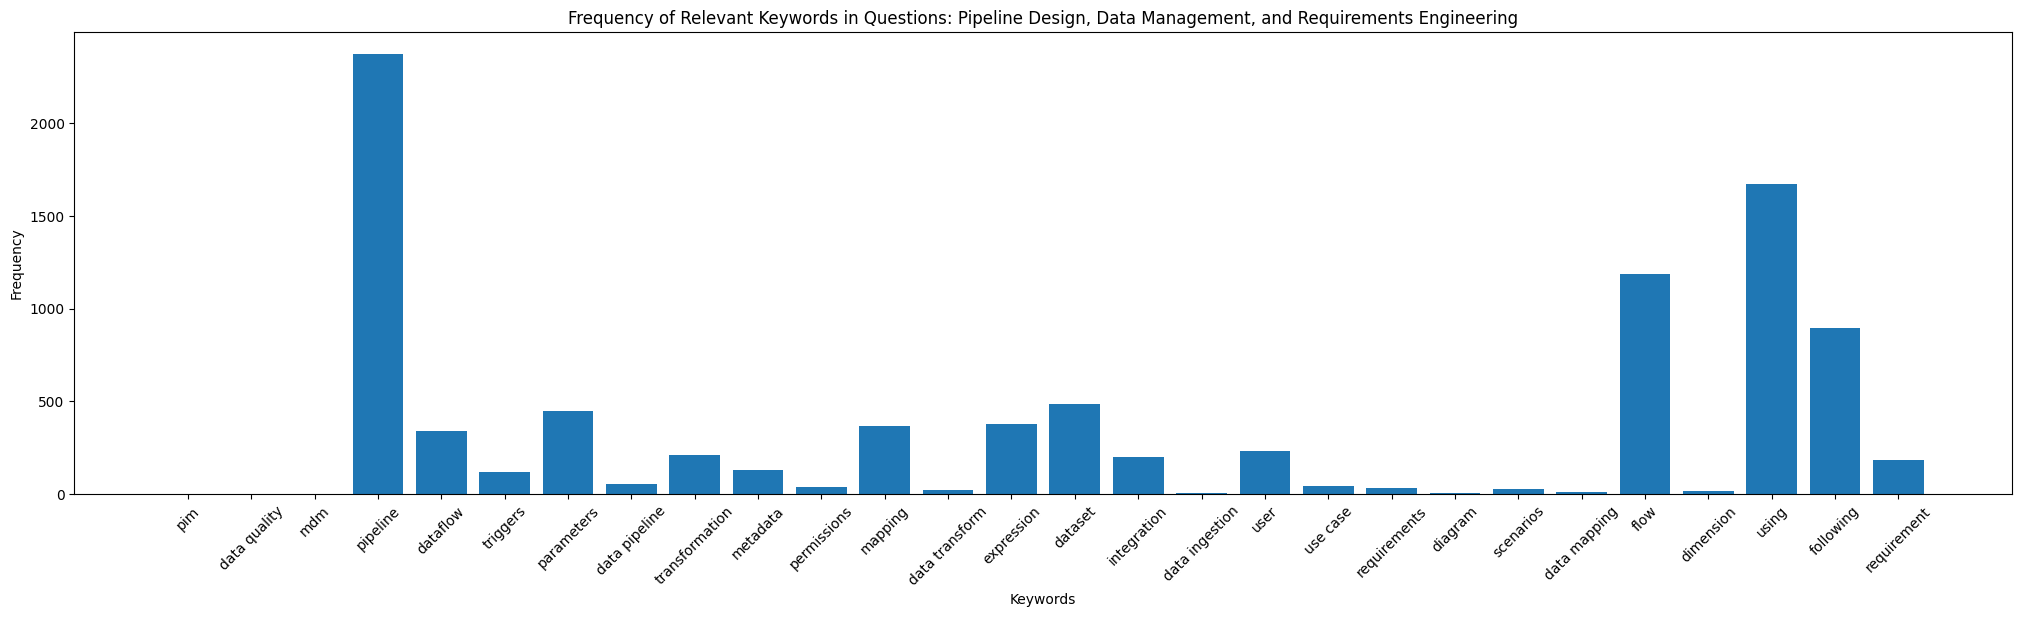

In [19]:
# Check for relevant keywords relating to requirements engineering, pipeline design, 
# data management or product data management. Keywords were deived from this and
# from previous queries

keywords_to_plot = ['pim', 'data quality', 'data governance', 'mdm','master data mangement', 'pipeline', 'dataflow', 'triggers', 'parameters', 'eventtrigger', 'data pipeline', 
                    'transformation', 'metadata', 'permissions', 'mapping',
                    'database-migration', 'database migration','snowflake-schema', 'snowflake schema', 'data transform',
                    'data-transform', 'networking', 'expression', 'dataset', 'integration', 'data-ingestion', 'data ingestion', 
                    'user', 'use case', 'system-requirements', 'system requirements', 
                    'use-case-diagram', 'use case diagram', 'requirements', 'modeling', 'diagram', 'scenarios', 
                    'data-synchronization', 'data synchronization', 'data-mapping', 
                    'data mapping', 'dataflow-diagram', 'dataflow diagram', 
                    'master-data-management', 'master data management', 'product-data-management', 'product data management' 
                    'product-data', 'product data', 'data-modelling', 'data modelling', 'dimensional-modelling', 
                    'dimensional modelling', 'star-schema', 'star schema' 'data-quality',
                    'business-intelligence', 'data-transformation', 'data transformation' 'actor', 'system-requirements', 
                    'system requirements', 'flow', 'dimension', 'using', 'following', 'requirement']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df2['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df2['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Set the figure size (width, height)
plt.figure(figsize=(25, 6))

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Relevant Keywords in Questions: Pipeline Design, Data Management, and Requirements Engineering')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Results**

The manually defined keywords in df2 can be interpreted as follows: 

The data set seems to center around data management in Azure Data Factory in general. Requirements engineering for data piplines is represented by keywords such as "user", "use case", "using", "actor". Data management is presented by keywords such as "flow", "dataflow", "data flow", "dimension", "data integration", "data mapping", "mapping", "etl". Data governance and data quality is represented by the verb "following". There is no significant mentioning of terms such as pim or mdm.

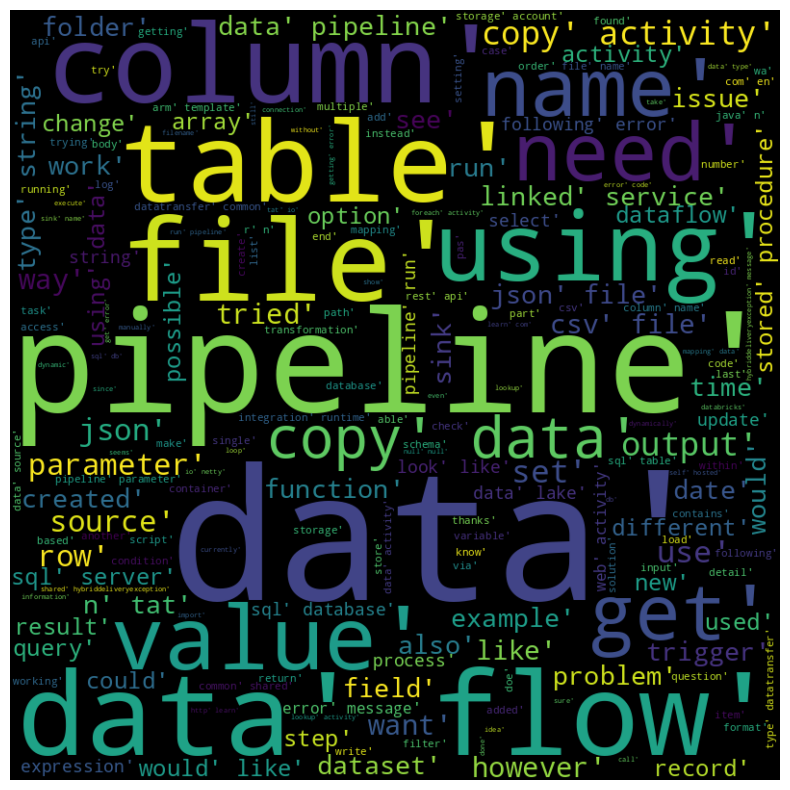

In [20]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stop_words and stop_phrases separately
stop_words = {'adf', 'azure', 'ha', 'microsoft', 'blob', 'factory', 'one', 'two', 
              'first', 'second', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u'
             }
stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(df2['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Extractions with spaCy**


In [21]:
from collections import defaultdict
import spacy
import re

# Define stop words and stop phrases
stop_words = {'microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in df2.iterrows():
    question_body = row['LemmatizedQuestionBody']
    
    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

Top 10 Entities
dominguez: 28
tom: 21
'quarter': 18
uk: 17
aml': 16
weekly: 15
bob: 15
friday: 13
michael: 12
workday: 12

Top 10 Nouns
data: 8608
pipeline: 5619
file: 4768
activity: 3678
type: 2956
error: 2849
name: 2819
source: 2736
column: 2703
table: 2697

Top 10 Verbs
using: 2542
get: 1979
run: 1543
want: 1439
need: 1403
following: 1128
set: 1119
trying: 1089
tried: 1019
create: 983



**Latent Dirichlet Allocation**

In [22]:
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df2['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 10  # Change this value to the desired number of topics
lda_model1 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(num_topics):
    print(f"Topic {topic + 1}:")
    top_words = lda_model1.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()

Topic 1:
  http: 0.0235
  c: 0.0213
  com: 0.0172
  api: 0.0167
  string: 0.0160
  b: 0.0155
  id: 0.0144
  token: 0.0128
  url: 0.0125
  using: 0.0116

Topic 2:
  activity: 0.0480
  file: 0.0455
  data: 0.0358
  pipeline: 0.0286
  azure: 0.0189
  copy: 0.0182
  blob: 0.0150
  get: 0.0145
  factory: 0.0114
  folder: 0.0111

Topic 3:
  feb: 0.0529
  json: 0.0450
  error: 0.0409
  get: 0.0401
  user: 0.0311
  supported: 0.0243
  help: 0.0233
  issue: 0.0216
  azure: 0.0211
  type: 0.0210

Topic 4:
  data: 0.0262
  value: 0.0210
  pipeline: 0.0177
  parameter: 0.0142
  activity: 0.0129
  column: 0.0126
  using: 0.0100
  like: 0.0100
  adf: 0.0090
  table: 0.0089

Topic 5:
  data: 0.0537
  azure: 0.0528
  pipeline: 0.0323
  need: 0.0206
  adf: 0.0172
  create: 0.0167
  able: 0.0148
  factory: 0.0138
  github: 0.0135
  call: 0.0134

Topic 6:
  service: 0.0349
  server: 0.0315
  linked: 0.0313
  sftp: 0.0301
  azure: 0.0261
  data: 0.0248
  pipeline: 0.0224
  failed: 0.0216
  connection: 0.0

In [23]:
# Check for total number of missing values
print(df2.isnull().sum().sum())

0


**Prompt GPT4:** This is a LDA. Give each topic a title. Discuss each topic individually:

**Response GPT4:** Here are the titles and discussions for each topic:

URL and API handling 

seems to be related to APIs and includes words such as http, c, api, string, etc. It could be related to questions about consuming APIs, programming language syntax, etc.

Azure Data Factory and File Processing 

appears to be related to data pipelines, specifically related to Azure Data Factory. It includes words such as activity, file, pipeline, azure, copy, blob, etc.

Errors and Troubleshooting 

appears to be related to error messages, user support, and issues with Azure services. It includes words such as feb, json, error, get, user, supported, help, issue, azure, type, etc.

Data Pipeline and Activity Parameterization

appears to be related to data columns, parameters, and data values. It includes words such as data, value, pipeline, parameter, activity, column, adf, table, etc.

Azure Data Factory and Github Integration

appears to be related to creating data pipelines using Azure Data Factory. It includes words such as data, azure, pipeline, adf, create, factory, etc.

Server and Data Connection

appears to be related to connecting to external services and servers, specifically through SFTP. It includes words such as service, server, linked, sftp, azure, data, pipeline, failed, connection, etc.

Dynamic File Name and Content Extraction

appears to be related to working with file names, content, and dynamic data. It includes words such as name, item, lastindexof, filename, csv, content, dynamic, data, factory, substring, etc.

CSV Data Source and Sink

appears to be related to working with data tables, sources, and sinks. It includes words such as data, table, file, column, row, source, sink, csv, error, azure, etc.

Data Type and Microsoft Error Handling

appears to be related to error messages and parameter types. It includes words such as type, microsoft, n, source, name, error, string, message, java, parameter, etc.

Pipeline Execution and Triggering

appears to be related to running data pipelines in Azure Data Factory. It includes words such as pipeline, run, trigger, factory, azure, data, etc.

Overall, these topics seem to cover a wide range of data pipeline-related topics such as error messages, parameters, connecting to external services, working with data tables, etc.

In [24]:
import numpy as np

# Define a function that safely evaluates literals
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return []

# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model1.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'URL and API handling',
        1: 'Azure Data Factory and File Processing',
        2: 'Errors and Troubleshooting',
        3: 'Data Pipeline and Activity Parameterization',
        4: 'Azure Data Factory and Github Integration',
        5: 'Server and Data Connection',
        6: 'Dynamic File Name and Content Extraction',
        7: 'CSV Data Source and Sink',
        8: 'Data Type and Microsoft Error Handling',
        9: 'Pipeline Execution and Triggering',
    }
    return topic_names.get(topic_index, '')

# Apply safe_literal_eval and assign_topic functions to the 'LemmatizedQuestionBody' column
df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(safe_literal_eval(x)))

# Assign topic names to a new column 'LDATopicName'
df2['LDATopicName'] = df2['LDATopic'].apply(get_topic_name)

# Check for total number of missing values
print(df2.isnull().sum().sum())

0


In [25]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model1.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

df2['LDATopic'] = df2['LemmatizedQuestionBody'].apply(lambda x: assign_topic(ast.literal_eval(x)))

In [26]:
# For the VADER Sentiment Analyzer it is reccommendet to use raw, unproecessed text the way it coems out of socail media.

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'AnswerBody' column and store the sentiment scores in a new column
df2['VaderSentimentScores'] = df2['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = df2.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)

# Note: The VADER sentiment analyzer is designed for social media texts and might not be the best choice 
# for your specific dataset. If you find that the sentiment analysis results are not accurate enough, 
# you can consider using other sentiment analysis libraries or training your own sentiment analysis model 
# using machine learning techniques.
#
# Some alternative sentiment analysis libraries include TextBlob and spaCy. You can also explore using
# pre-trained models for sentiment analysis from popular NLP libraries like Hugging Face's Transformers.

# This code will apply the VADER sentiment analyzer to each answer in the DataFrame, store the sentiment 
# scores in a new column called SentimentScores, and calculate the average sentiment score for each topic. 
# The limitations and suggestions for alternative approaches are provided as comments within the code.


LDATopicName                                         
Azure Data Factory and File Processing       neg         0.032181
                                             neu         0.913090
                                             pos         0.054721
                                             compound    0.177393
Azure Data Factory and Github Integration    neg         0.025506
                                             neu         0.917078
                                             pos         0.057367
                                             compound    0.276070
CSV Data Source and Sink                     neg         0.030499
                                             neu         0.914386
                                             pos         0.055133
                                             compound    0.204641
Data Pipeline and Activity Parameterization  neg         0.026258
                                             neu         0.905311
                      

The topics have a neutral sentiment while the compound scores are positive with exceptions in "Data Type and Microsoft Error Handling" and "Errors and Troubleshooting". The latter have negative compound scores of -0.2398 and -0.2470, respectively.

In [27]:
topic_distribution = df2['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
Data Pipeline and Activity Parameterization    1925
Azure Data Factory and File Processing          724
Pipeline Execution and Triggering               371
CSV Data Source and Sink                        339
URL and API handling                            247
Azure Data Factory and Github Integration       166
Data Type and Microsoft Error Handling          155
Dynamic File Name and Content Extraction         49
Server and Data Connection                       47
Errors and Troubleshooting                       12
Name: count, dtype: int64


In [28]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

def custom_topic_names(topic_number):
    topic_names = {
        0: 'URL and API handling',
        1: 'Azure Data Factory and File Processing',
        2: 'Errors and Troubleshooting',
        3: 'Data Pipeline and Activity Parameterization',
        4: 'Azure Data Factory and Github Integration',
        5: 'Server and Data Connection',
        6: 'Dynamic File Name and Content Extraction',
        7: 'CSV Data Source and Sink',
        8: 'Data Type and Microsoft Error Handling',
        9: 'Pipeline Execution and Triggering',
    }
    return topic_names.get(topic_number, '')

lda_viz = gensimvis.prepare(lda_model1, corpus, dictionary)

for i in range(num_topics):
    lda_viz.topic_info.loc[lda_viz.topic_info.Category == f'Topic{i+1}', 'Category'] = custom_topic_names(i)
    lda_viz.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

pyLDAvis.display(lda_viz)

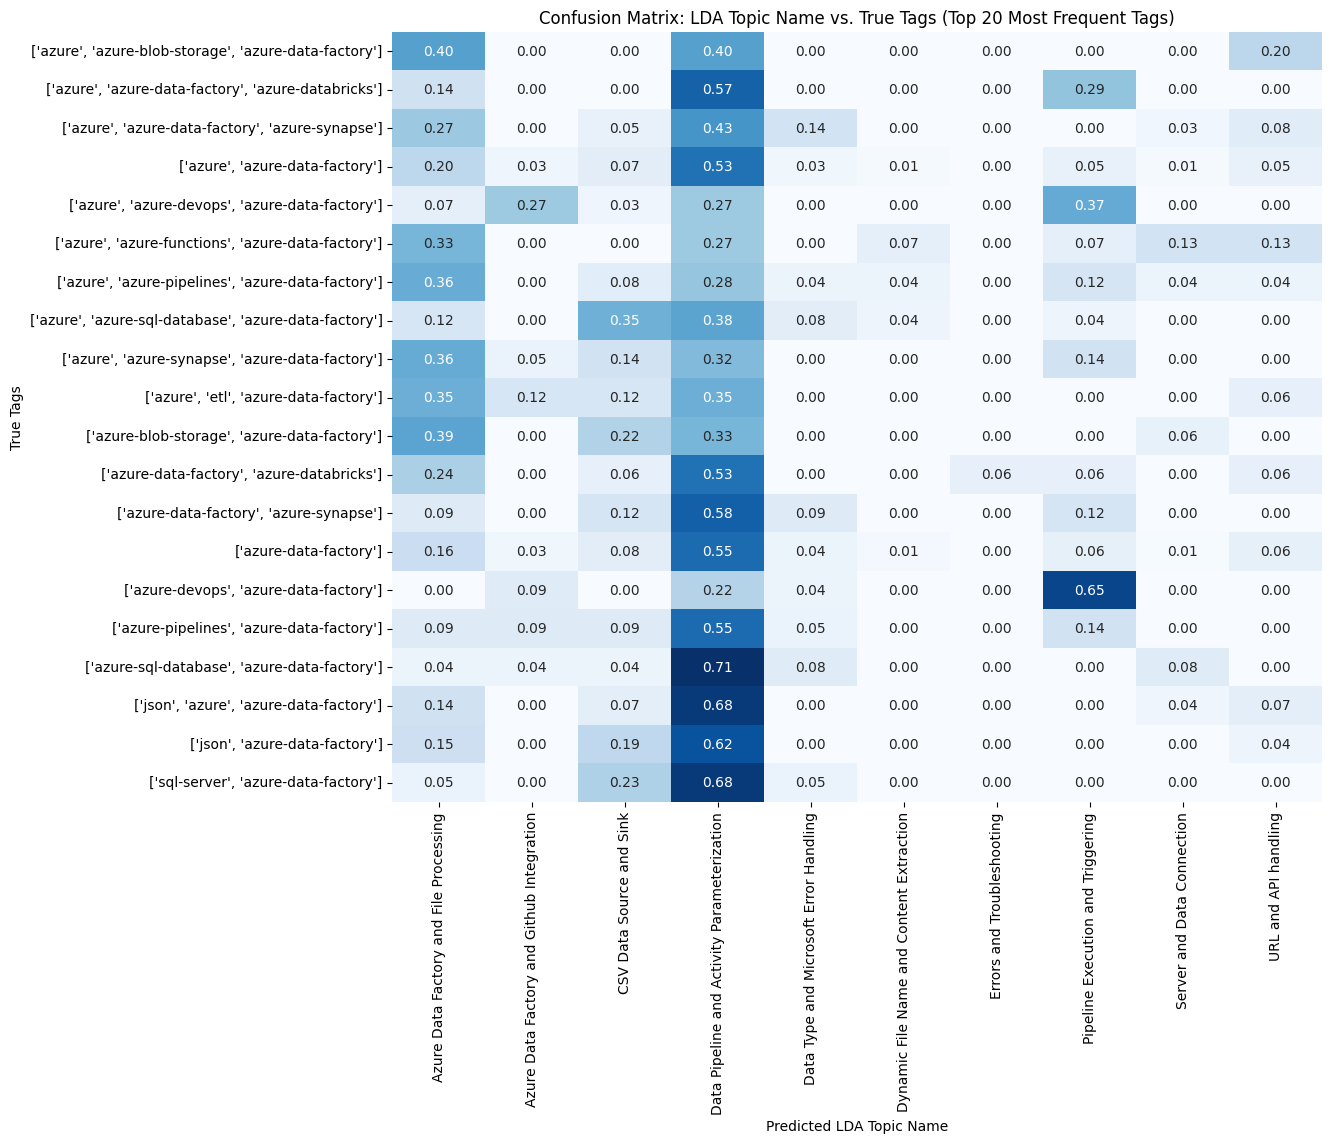

In [39]:
df2_top_n_tags = 20

# Get the top N most frequent tags
df2_top_tags = df2['Tags'].value_counts().nlargest(df2_top_n_tags).index.tolist()

# Filter the dataset
df2_filtered_df2 = df2[df2['Tags'].isin(df2_top_tags)]

# Create a confusion matrix
confusion_matrix = pd.crosstab(df2_filtered_df2['Tags'], df2_filtered_df2['LDATopicName'])

# Normalize the confusion matrix by row to show proportions
df2_normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)


plt.figure(figsize=(12, 10))
sns.heatmap(df2_normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(top_n_tags))
plt.show()

# This heatmap provides insights into the relationship between the true tags and the LDA topic 
# names, helping to evaluate the performance of the LDA model in terms of topic extraction. 
# Ideally, if the LDA model is performing well, there should be a strong diagonal pattern in 
# the heatmap, indicating that most true tags correspond to the predicted LDA topic names.

C:\Users\TanjaWolf_7ms6v6m\AppData\Local\Temp\ipykernel_7388\397443292.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_filtered.loc[:, 'KeywordStrength'] = df2_filtered.apply(lambda row: compute_keyword_strength(row, keywords), axis=1)


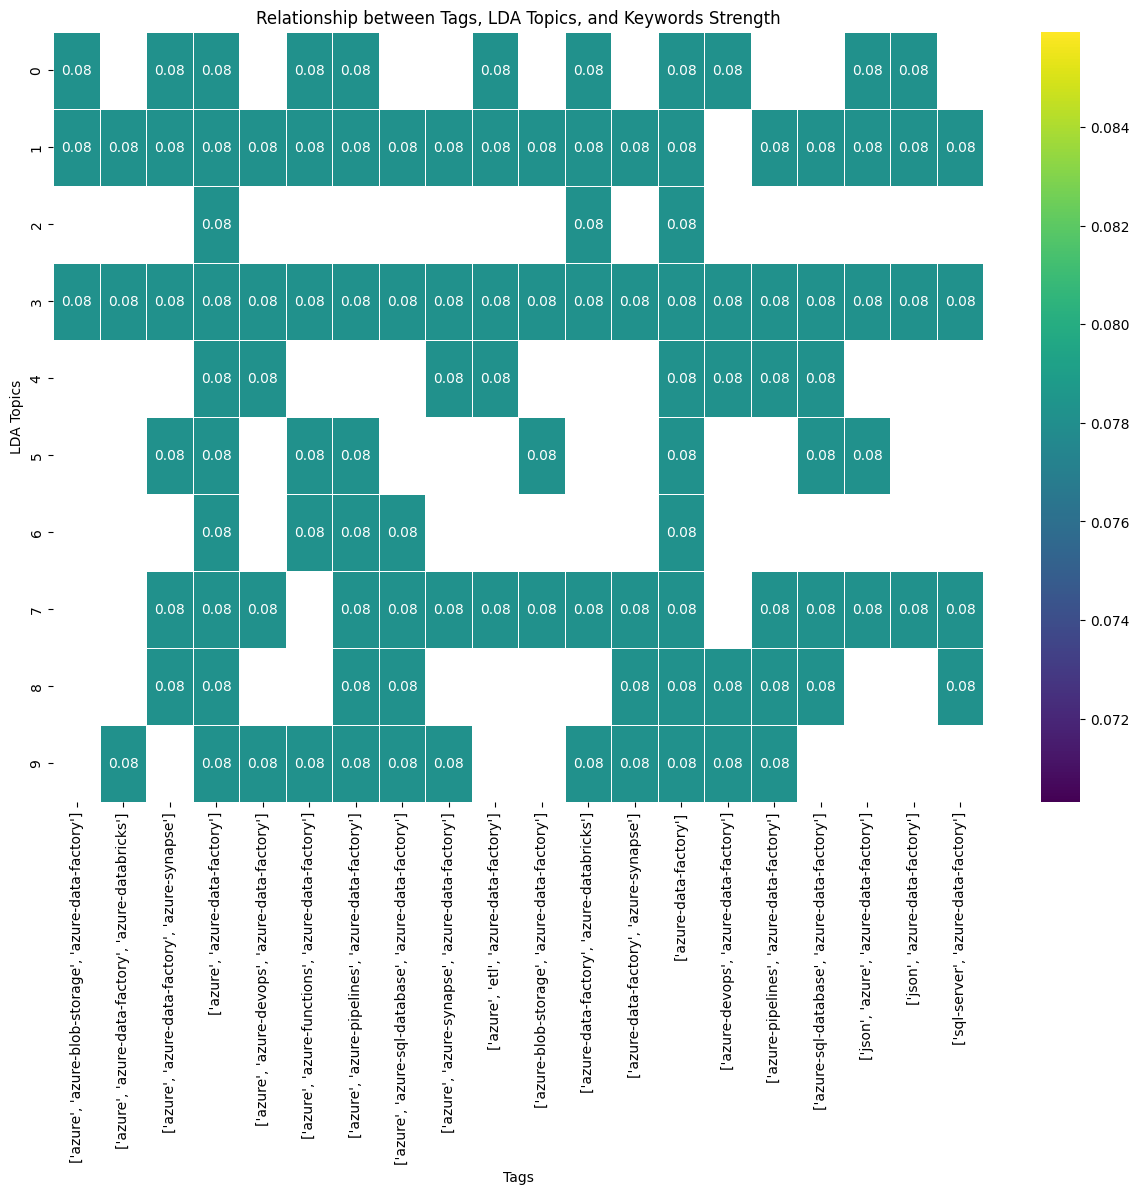

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast

def extract_keywords(text, keywords, n_keywords=5):
    words = text.split()
    keyword_count = {keyword: words.count(keyword) for keyword in keywords}
    sorted_keywords = sorted(keyword_count, key=keyword_count.get, reverse=True)
    return sorted_keywords[:n_keywords]

def compute_keyword_strength(row, keywords):
    extracted_keywords = extract_keywords(row['QuestionBody'], keywords)
    keyword_strength = len(extracted_keywords) / len(keywords)
    return keyword_strength

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df2['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 10  # Change this value to the desired number of topics
lda_model1 = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
#for topic in range(num_topics):
   # print(f"Topic {topic + 1}:")
    #top_words = lda_model1.show_topic(topic, topn=words_per_topic)
    #for word, weight in top_words:
        #print(f"  {word}: {weight:.4f}")
    #print()

# Extract the top keywords from the LDA topics
keywords = set()
for topic in range(num_topics):
    top_words = lda_model1.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        keywords.add(word)

# Filter the data to only include the top tags and topics
top_n_tags = 20
top_n_topics = 10
top_tags = df2['Tags'].value_counts().nlargest(top_n_tags).index.tolist()
df2_filtered = df2[(df2['Tags'].isin(top_tags)) & (df2['LDATopic'] < top_n_topics)]

# Compute keyword strength for each data point
df2_filtered.loc[:, 'KeywordStrength'] = df2_filtered.apply(lambda row: compute_keyword_strength(row, keywords), axis=1)

# Create a pivot table with tags on the x-axis, topics on the y-axis, and mean keyword strength as the cell value
pivot_table = df2_filtered.pivot_table(index='LDATopic', columns='Tags', values='KeywordStrength', aggfunc=np.mean)

# Create a pivot table with tags on the x-axis, topics on the y-axis, and mean keyword strength as the cell value:

pivot_table = df2_filtered.pivot_table(index='LDATopic', columns='Tags', values='KeywordStrength', aggfunc=np.mean)
# Create a heatmap to visualize the pivot table

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.2f', linewidths=.5)
plt.xlabel('Tags')
plt.ylabel('LDA Topics')
plt.title('Relationship between Tags, LDA Topics, and Keywords Strength')

plt.show()


In [ ]:
#df2.to_csv('adf_df2_with_lda.csv', index=True)

In [41]:
# Reset the index in both dataframes
df = df.reset_index()
df2 = df2.reset_index()

# Convert the 'LDATopic' column to integers
df2['LDATopic'] = pd.to_numeric(df2['LDATopic'], errors='coerce')

# Fill missing values in the 'LDATopic' column with 11
df2['LDATopic'] = df2['LDATopic'].fillna(11)

# Perform a left merge on the common column ('index' in this case)
merged_df2 = df.merge(df2[['index', 'LDATopic']], on='index', how='left')

# Drop the 'index' column
merged_df2 = merged_df2.drop(columns=['index'])

# Fill missing values in the 'LDATopic' column with 11
merged_df2['LDATopic'] = merged_df2['LDATopic'].fillna(11)

In [42]:
len(merged_df2)

8547

In [43]:
topic_distribution = merged_df2['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11.0    4512
3.0     1924
1.0      724
9.0      370
7.0      340
0.0      248
4.0      166
8.0      155
6.0       49
5.0       47
2.0       12
Name: count, dtype: int64


In [ ]:
#merged_df2.to_csv('merged_adf_df2_with_no_lda.csv', index=True)

In [44]:
# Filter rows where LDATopic is 11 and not NaN
df2_rows = merged_df2[(merged_df2['LDATopic'] == 11) & (merged_df2['LDATopic'].notna())]

# Transform the text data in the remaining rows
text_data_df2 = df2_rows['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()
corpus_df2 = [dictionary.doc2bow(document) for document in text_data_df2]

# Predict the topics for the transformed data using the LDA model
predicted_topics_df2 = [lda_model1.get_document_topics(corpus_item) for corpus_item in corpus_df2]

# Set the probability threshold
threshold = 0.5

# Assign topics only if the maximum probability is above the threshold
predicted_topic_labels_filtered = []
for topic_probs in predicted_topics_df2:
    max_prob = max(topic_prob for topic_id, topic_prob in topic_probs)
    if max_prob >= threshold:
        topic_label = np.argmax([topic_prob for topic_id, topic_prob in topic_probs])
    else:
        topic_label = 11  # Assign the value 11 for rows with low probability
    predicted_topic_labels_filtered.append(topic_label)

# Update the 'LDATopic' column with the filtered predicted topics
df2_indices = df2_rows.index
predicted_topic_labels_filtered = np.array(predicted_topic_labels_filtered).astype(int)
merged_df2.loc[df2_indices, 'LDATopic'] = predicted_topic_labels_filtered

In [45]:
topic_distribution = merged_df2['LDATopic'].value_counts()
print(topic_distribution)

LDATopic
11.0    2912
3.0     1996
1.0     1313
0.0      863
9.0      375
7.0      343
2.0      264
4.0      204
8.0      155
5.0       65
6.0       57
Name: count, dtype: int64


In [46]:
topic_names = {
    0: 'URL and API handling',
    1: 'Azure Data Factory and File Processing',
    2: 'Errors and Troubleshooting',
    3: 'Data Pipeline and Activity Parameterization',
    4: 'Azure Data Factory and Github Integration',
    5: 'Server and Data Connection',
    6: 'Dynamic File Name and Content Extraction',
    7: 'CSV Data Source and Sink',
    8: 'Data Type and Microsoft Error Handling',
    9: 'Pipeline Execution and Triggering',
    11: 'No Topic Assigned'
    }
merged_df2['LDATopicName'] = merged_df2['LDATopic'].map(topic_names)


topic_distribution = merged_df2['LDATopicName'].value_counts()
print(topic_distribution)

LDATopicName
No Topic Assigned                              2912
Data Pipeline and Activity Parameterization    1996
Azure Data Factory and File Processing         1313
URL and API handling                            863
Pipeline Execution and Triggering               375
CSV Data Source and Sink                        343
Errors and Troubleshooting                      264
Azure Data Factory and Github Integration       204
Data Type and Microsoft Error Handling          155
Server and Data Connection                       65
Dynamic File Name and Content Extraction         57
Name: count, dtype: int64


In [47]:
len(merged_df2)

8547

In [48]:
# Transform the text data in merged_df2
text_data_merged_df2 = merged_df2['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()
corpus_merged_df2 = [dictionary.doc2bow(document) for document in text_data_merged_df2]

# Predict the topics for the transformed data using the LDA model
predicted_topics_merged_df2 = [lda_model1.get_document_topics(corpus_item) for corpus_item in corpus_merged_df2]

# Prepare the LDA visualization for merged_df2
lda_viz_merged_df2 = gensimvis.prepare(lda_model1, corpus_merged_df2, dictionary)

# Update the topic names in the LDA visualization for merged_df2
for i in range(num_topics):
    lda_viz_merged_df2.topic_info.loc[lda_viz_merged_df2.topic_info.Category == f'Topic{i+1}', 'Category'] = custom_topic_names(i)
    lda_viz_merged_df2.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

# Display the LDA visualization for merged_df2
pyLDAvis.display(lda_viz_merged_df2)

In [49]:
In the LDA visualization created by pyLDAvis, the x and y axes represent the first two dimensions of a multi-dimensional scaling (MDS) or principal component analysis (PCA) projection. The purpose of these axes is to provide a two-dimensional representation of the topics in a way that reflects their similarity or dissimilarity.

The distance between topics in this two-dimensional space represents their similarity or dissimilarity. Topics that are closer to each other are more similar, meaning they share more common words, while topics further apart are more dissimilar and have less overlap in their word distributions.

It is important to note that the x and y axes themselves do not have specific meanings or interpretations. They are just dimensions that help to visualize and explore the relationships among topics. The actual interpretation comes from the relative positions of the topics in the plot and their corresponding word distributions.

SyntaxError: invalid syntax (142429040.py, line 1)

In [50]:
merged_df2.columns

Index(['Unnamed: 0', 'QuestionId', 'QuestionTitle', 'QuestionBody',
       'QuestionTags', 'Date', 'ViewCount', 'Score', 'NumberOfAnswers',
       'AnswerId', 'AnswerBody', 'SplitTags', 'YearMonth',
       'CleanedQuestionBody', 'CleanedAnswerBody', 'Tags', 'TagsInTitle',
       'TokenizedQuestionBody', 'TokenizedAnswerBody',
       'LemmatizedQuestionBody', 'LemmatizedAnswerBody', 'CreationDate',
       'LDATopic', 'LDATopicName'],
      dtype='object')

In [51]:
#merged_df2.to_csv('merged_df2_with_lda.csv', index=True)

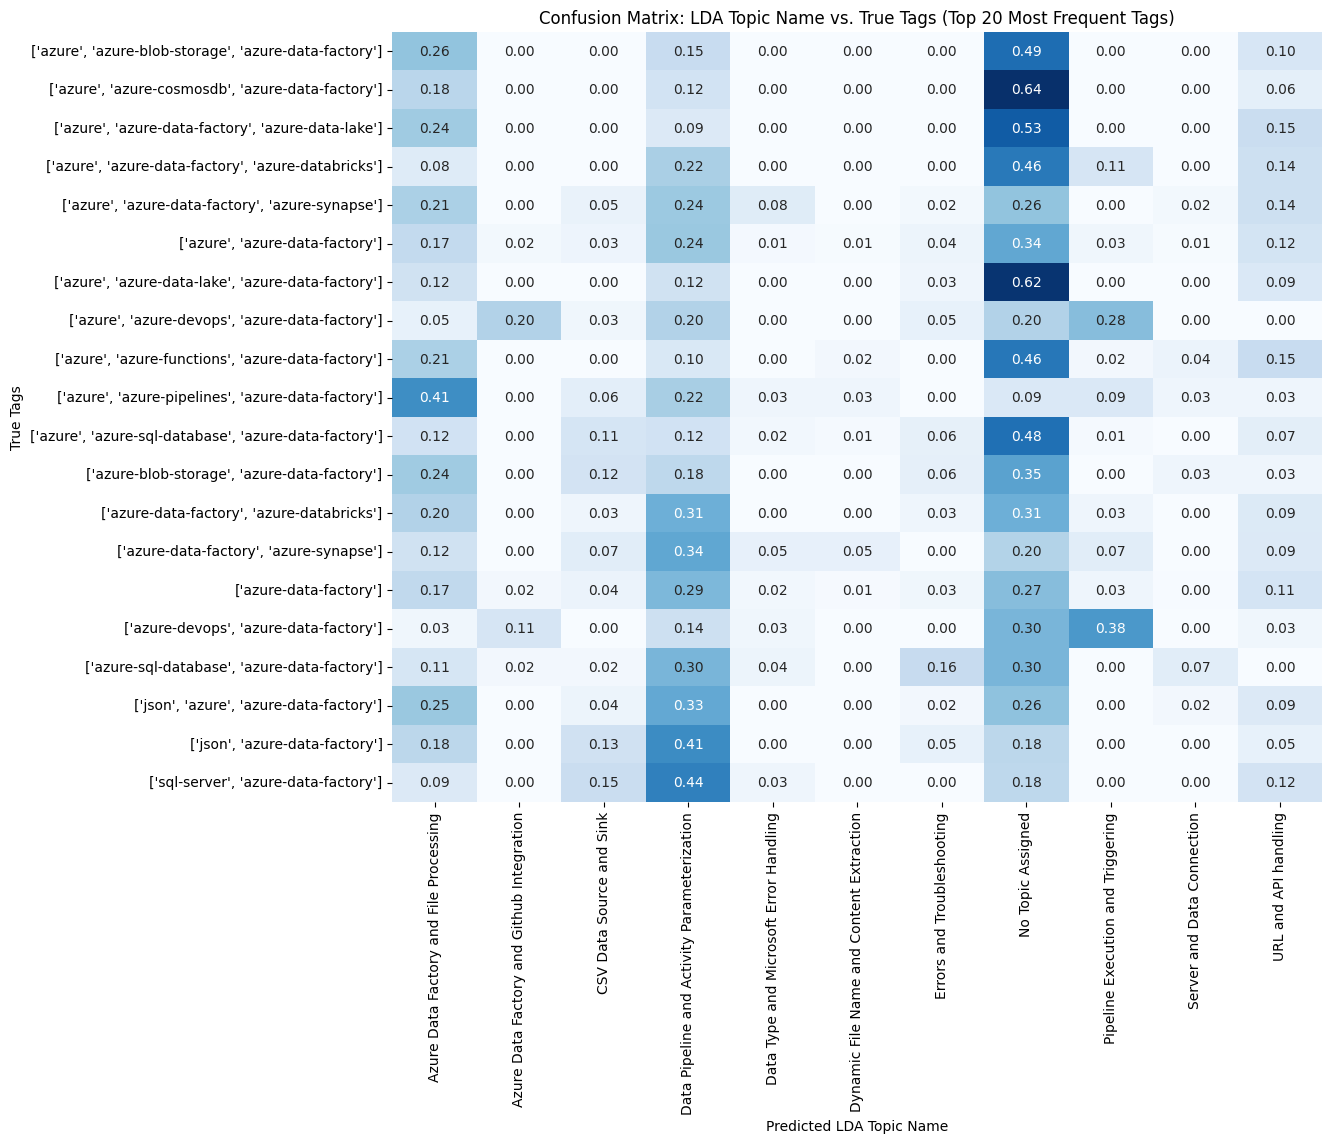

In [52]:
top_n_tags = 20

# Get the top N most frequent tags
top_tags = merged_df2['Tags'].value_counts().nlargest(top_n_tags).index.tolist()

# Filter the dataset
filtered_df2 = merged_df2[merged_df2['Tags'].isin(top_tags)]

# Create a confusion matrix
confusion_matrix = pd.crosstab(filtered_df2['Tags'], filtered_df2['LDATopicName'])

# Normalize the confusion matrix by row to show proportions
normalized_confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)


plt.figure(figsize=(12, 10))
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)

plt.xlabel('Predicted LDA Topic Name')
plt.ylabel('True Tags')
plt.title('Confusion Matrix: LDA Topic Name vs. True Tags (Top {} Most Frequent Tags)'.format(top_n_tags))
plt.show()

#This will create a heatmap of the confusion matrix for the top N most frequent tags, making the plot less cluttered and easier to interpret.




The heatmap displays a confusion matrix that shows the relationship between the true tags (ground truth) and the LDA topic names (predicted topics) for the top N most frequent tags in the dataset. Each cell in the heatmap represents the proportion of times a specific true tag was assigned to a particular LDA topic name.

The color gradient, with lighter shades indicating higher proportions, helps in visualizing the strength of the relationship between the true tags and the LDA topic names. In other words, the heatmap allows you to understand how well the LDA model captures the underlying topics for the most frequent tags in your dataset. Cells with higher proportions (lighter shades) suggest that the LDA model has identified a strong relationship between the true tag and the corresponding LDA topic name.

In [ ]:
df4 =filtered_df_lda.copy()

In [ ]:
#df4.to_csv('lda_df3.csv', index=True)

In [ ]:
# Analyze the distribution of questions over time:

df4['YearMonth'] = df4['Date'].dt.to_period('M')

question_count_by_month = df4.groupby('YearMonth')['QuestionId'].nunique()
question_count_by_month.plot()
plt.xlabel('Year-Month')
plt.ylabel('Number of Questions')
plt.title('Number of Questions by Month')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you already have a DataFrame called 'df'

# Find and extract tags
df4['SplitTags'] = df4['QuestionTags'].str.findall('<(.*?)>')

# Explode the DataFrame to have one row per tag
exploded_df = df4.explode('SplitTags')

# Filter out tags containing "azure" and the empty tag
filtered_df = exploded_df[~exploded_df['SplitTags'].str.contains('azure', na=False) & (exploded_df['SplitTags'] != '')]

# Count the non-"azure" tags
non_azure_tags = filtered_df['SplitTags'].values
non_azure_tag_counts = Counter(non_azure_tags)

# Display the top 20 non-"azure" tags
most_common_non_azure_tags = non_azure_tag_counts.most_common(20)

plt.barh([tag for tag, _ in most_common_non_azure_tags], [count for _, count in most_common_non_azure_tags])
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Common Non-"Azure" Tags')
plt.show()

In [ ]:
# Check for keywords relating to requirements engineering, master data management or product data management
# Relevant keywords from requirements engineering data sets:

keywords_to_plot = ['user','actor','use case', 'specifications', 'system requirements', 'use case diagram', 'requirements', 'requirements', 
                    'catalog', 'system requirements', 'specifications', 'modeling', 'diagram', 'scenarios', 'flow', 'dimension', 
                    'dimension modelling', 'mdm', 'data synchronization', 'etl', 
                    'master data management', 'product data management',
                    'data modelling', 'dimensional modelling', 'star schema', 'data quality', 
                    'buisness intelligence', 'data Transformation', 'data flow', 'pipeline', 'dataflow', 
                    'activity', 'flow', 'dimension', 'dimension modelling','data mapping', 
                    'mapping', 'azure mapping data flow',
                    'star schema', 'data mapping', 'data Transformation', 
                    'data flow', 'pipeline', 'triggers', 'parameters', 'eventtrigger', 'data pipeline', 'transformation', 
                    'metadata', 'permissions', 'data migration', 'database migration', 'snowflake schema', 'data transform', 'networking', 
                    'expression', 'dataset', 'integration', 'data-ingestion', 'user', 'use-case', 'specifications', 'system-requirements', 
                    'requirements', 'requirement', 'catalog', 'system requirements', 'modeling', 'modelling', 
                    'diagram', 'data integration', 'dataflow diagram', 
                    'dimensional modelling',
                    'star schema', 'data Transformation', 'using', 'following']

# Filter the keywords based on their presence in the 'QuestionTitle' column
keywords_to_plot = [keyword for keyword in keywords_to_plot if any(keyword in title for title in df4['QuestionBody'])]

# Count the occurrences of each keyword in the 'QuestionTitle' column
keyword_counts = {keyword: df4['QuestionBody'].apply(lambda title: keyword in title).sum() for keyword in keywords_to_plot}

# Set the figure size (width, height)
plt.figure(figsize=(25, 6))

# Create a bar plot
plt.bar(keyword_counts.keys(), keyword_counts.values())
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Selected Keywords in Questions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
import spacy
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define stop_words and stop_phrases separately
stop_words = {'adf', 'azure', 'ha', 'microsoft', 'blob', 'factory', 'one', 'two', 
              'first', 'second', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u'
             }
stop_phrases = {'azure data', 'data factory', 'u u', 'azure data factory', 'azure pipeline', 'azure synapse', 
                  'azure sql database', 'azure data lake', 'azure blob storage', 'azure databricks', 'azure devops'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Load the English language model
nlp = spacy.load('en_core_web_lg')

# Combine all the preprocessed texts into a single string
preprocessed_texts = ' '.join(df4['LemmatizedQuestionBody'].astype(str))

# Remove stop words and stop phrases from the preprocessed_texts
for stopword in all_stop_words:
    preprocessed_texts = re.sub(r'\b' + re.escape(stopword) + r'\b', '', preprocessed_texts, flags=re.IGNORECASE)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800)

# Generate the word cloud with a larger size (e.g., 800x800) and the preprocessed_texts without stopwords
cloud = wordcloud.generate(preprocessed_texts.lower())

# Display the word cloud
plt.figure(figsize=(10, 10))  # Increase the figure size for better visibility
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from collections import defaultdict
import spacy
import re

# Define stop words and stop phrases
stop_words = {'adf','microsoft', 'factory', 'one', 'u u', 'two', 
              'first', 'second', 'azure', 'max', 'mm', 'abc', 
              'three', 'third', 'mm dd', 'apache', 'today', 
              'org apache', 'month', 'qnaid qna', 'azure data', 
              'prem', 'year', 'donesafe', 'day', 'month', 'hour',
              'year', 'yyyy', 'minute', 'daily', 'bi', 'week', 'u', 
              'europe', 'ec', 'tenant_id', 'thousand', 'yesterday',
              'adl', 'jan', 'monthly', 'to_date', 'subscription_id', 'created'
             }
stop_phrases = {'azure data', 'data factory', 'u u'}

# Convert stop words and phrases to lowercase
stop_words = {word.lower() for word in stop_words}
stop_phrases = {phrase.lower() for phrase in stop_phrases}

# Combine stop_words and stop_phrases into one set
all_stop_words = stop_words.union(stop_phrases)

# Analyze the text and extract entities, nouns, and verbs
entities_counter = defaultdict(int)
nouns_counter = defaultdict(int)
verbs_counter = defaultdict(int)

for _, row in df4.iterrows():
    question_body = row['LemmatizedQuestionBody']
    
    # Remove stop words and stop phrases from the question_body
    for stopword in all_stop_words:
        question_body = re.sub(r'\b' + re.escape(stopword) + r'\b', '', question_body, flags=re.IGNORECASE)
    
    doc = nlp(question_body)
        
    for ent in doc.ents:
        if ent.text.lower() not in stop_words:
            entities_counter[ent.text.lower()] += 1
        
    for token in doc:
        if token.pos_ == 'NOUN' and token.is_alpha and token.text.lower() not in stop_words:
            nouns_counter[token.text.lower()] += 1
        elif token.pos_ == 'VERB' and token.is_alpha and token.text.lower() not in stop_words:
            verbs_counter[token.text.lower()] += 1

# Display the top 10 most common entities, nouns, and verbs
def display_top_n(counter, n, title):
    print(title)
    for item, count in sorted(counter.items(), key=lambda x: x[1], reverse=True)[:n]:
        print(f"{item}: {count}")
    print()

display_top_n(entities_counter, 10, "Top 10 Entities")
display_top_n(nouns_counter, 10, "Top 10 Nouns")
display_top_n(verbs_counter, 10, "Top 10 Verbs")

In [ ]:
import numpy as np
import random
import gensim
from gensim import corpora
from gensim.models import LdaModel
import ast

# Prepare the input data by using the lemmatized tokens from the 'LemmatizedQuestionBody' column:
documents = df4['LemmatizedQuestionBody'].apply(ast.literal_eval).tolist()

# Set the random seed for numpy and python to ensure the same results each time the allocation re-runs
np.random.seed(42)
random.seed(42)

# Create a dictionary and a bag of words corpus from the documents:
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Set the seed for the random number generator used by the LDA model to a fixed value. 
# Ensures that the same sequence of random numbers is generated every time the model is trained 
# with the same input data and configuration.
random_state_seed = 42 
gensim.models.ldamodel.LdaModel.seed = random_state_seed

# Train the LDA model. You can choose the number of topics by setting the num_topics parameter:
num_topics = 10  # Change this value to the desired number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15) # Set the number of passes

# Display the top words for each topic
words_per_topic = 10  # Specify the number of top words per topic
for topic in range(num_topics):
    print(f"Topic {topic + 1}:")
    top_words = lda_model.show_topic(topic, topn=words_per_topic)
    for word, weight in top_words:
        print(f"  {word}: {weight:.4f}")
    print()

**GPT4 Propmt** These are the results of the lda for df4. Give each topic a name. Discuss the results of each topic individually (Include code of the original sql query and the filtering for the sub-set data frames)

**GPT4 result** Based on the top words for each topic, we can assign descriptive names to each topic:


Based on the top words in each topic, here are my suggested names for the topics:

    JSON and Data Activity
    Error Handling and Notification
    Table Data and Query Execution
    Data Type and Source
    JSON and Document Attributes
    Azure Function and PowerShell
    File Handling and Copying
    Azure Data Factory and Pipeline Execution
    Parameterization and Expression
    Data Flow and SQL Table

Topic 1 seems to be related to working with JSON data and data activities. Topic 2 seems to be related to error handling and notification mechanisms. Topic 3 seems to be related to working with table data and executing queries. Topic 4 seems to be related to data types and data sources. Topic 5 seems to be related to working with JSON and document attributes. Topic 6 seems to be related to Azure Function and PowerShell. Topic 7 seems to be related to file handling and copying. Topic 8 seems to be related to Azure Data Factory and pipeline execution. Topic 9 seems to be related to parameterization and expression. Topic 10 seems to be related to data flow and SQL tables.

It is important to note that the names I assigned to the topics are based solely on the top words in each topic and should be considered as tentative. Further analysis and understanding of the context of the questions in the dataset may lead to more accurate names.

In [ ]:
import numpy as np

# Define a function that safely evaluates literals
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return []

# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

# Define a function that returns the topic name based on the index
def get_topic_name(topic_index):
    topic_names = {
        0: 'JSON and Data Activity',
        1: 'Error Handling and Notification',
        2: 'Table Data and Query Execution', 
        3: 'Data Type and Source',
        4: 'JSON and Document Attributes',  
        5: 'Azure Function and PowerShell',
        6: 'File Handling and Copying',
        7: 'Azure Data Factory and Pipeline Execution',
        8: 'Parameterization and Expression',
        9: 'Data Flow and SQL Table',
    }
    return topic_names.get(topic_index, '')

# Apply safe_literal_eval and assign_topic functions to the 'LemmatizedQuestionBody' column
df4['LDATopic'] = df4['LemmatizedQuestionBody'].apply(lambda x: assign_topic(safe_literal_eval(x)))

# Assign topic names to a new column 'LDATopicName'
df4['LDATopicName'] = df4['LDATopic'].apply(get_topic_name)

# Check for total number of missing values
print(df4.isnull().sum().sum())

In [ ]:
# Assign each question to its most relevant topic:
def assign_topic(document):
    bow = dictionary.doc2bow(document)
    topic_distribution = lda_model.get_document_topics(bow)
    most_relevant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return most_relevant_topic

df4['LDATopic'] = df4['LemmatizedQuestionBody'].apply(lambda x: assign_topic(ast.literal_eval(x)))



In [ ]:
print(df4.isnull().sum().sum())

In [ ]:
# For the VADER Sentiment Analyzer it is reccommendet to use raw, unproecessed text the way it coems out of socail media.

import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate the sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply the function to the 'AnswerBody' column and store the sentiment scores in a new column
df4['VaderSentimentScores'] = df4['QuestionBody'].apply(get_sentiment_score)

# Calculate the average sentiment score for each topic
avg_sentiment_by_topic = df4.groupby('LDATopicName')['VaderSentimentScores'].apply(lambda scores: pd.DataFrame(scores.tolist()).mean())

print(avg_sentiment_by_topic)

# Note: The VADER sentiment analyzer is designed for social media texts and might not be the best choice 
# for your specific dataset. If you find that the sentiment analysis results are not accurate enough, 
# you can consider using other sentiment analysis libraries or training your own sentiment analysis model 
# using machine learning techniques.
#
# Some alternative sentiment analysis libraries include TextBlob and spaCy. You can also explore using
# pre-trained models for sentiment analysis from popular NLP libraries like Hugging Face's Transformers.

# This code will apply the VADER sentiment analyzer to each answer in the DataFrame, store the sentiment 
# scores in a new column called SentimentScores, and calculate the average sentiment score for each topic. 
# The limitations and suggestions for alternative approaches are provided as comments within the code.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

def custom_topic_names(topic_number):
    topic_names = {
        0: 'JSON and Data Activity',
        1: 'Error Handling and Notification',
        2: 'Table Data and Query Execution', 
        3: 'Data Type and Source',
        4: 'JSON and Document Attributes',  
        5: 'Azure Function and PowerShell',
        6: 'File Handling and Copying',
        7: 'Azure Data Factory and Pipeline Execution',
        8: 'Parameterization and Expression',
        9: 'Data Flow and SQL Table',
    }
    return topic_names.get(topic_number, '')

lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)

for i in range(num_topics):
    lda_viz.topic_info.loc[lda_viz.topic_info.Category == f'Topic{i+1}', 'Category'] = custom_topic_names(i)
    lda_viz.topic_coordinates.loc[i, 'topics'] = custom_topic_names(i)

pyLDAvis.display(lda_viz)

In [ ]:
topic_distribution = df4['LDATopic'].value_counts()
print(topic_distribution)

In [ ]:
topic_distribution = df4['LDATopicName'].value_counts()
print(topic_distribution)

In [ ]:
df4.head(1)

In [ ]:
len(df4)

In [ ]:
#df4.to_csv('lda_df4.csv', index=True)

In [ ]:
# This code resets the index of two data frames, converts the 'LDATopic' column of df4 to integers and fills the missing values in that column with 11. 
# It then merges the two data frames on the common column 'index' using a left merge and drops the 'index' column from the merged data frame. 
# Finally, it fills the missing values in the 'LDATopic' column of the merged data frame with 11.

# Reset the index in both dataframes
df = df.reset_index()
df4 = df4.reset_index()

# Convert the 'LDATopic' column to integers
df4['LDATopic'] = pd.to_numeric(df4['LDATopic'], errors='coerce')

# Fill missing values in the 'LDATopic' column with 11
df4['LDATopic'] = df4['LDATopic'].fillna(11)

# Perform a left merge on the common column ('index' in this case)
merged_df4 = df.merge(df4[['index', 'LDATopic']], on='index', how='left')

# Drop the 'index' column
merged_df4 = merged_df4.drop(columns=['index'])

# Fill missing values in the 'LDATopic' column with 11
merged_df4['LDATopic'] = merged_df4['LDATopic'].fillna(11)

In [ ]:
len(merged_df4)

In [ ]:
topic_distribution = merged_df4['LDATopic'].value_counts()
print(topic_distribution)

In [ ]:
#merged_df.to_csv('merged_df4_no_lda.csv', index=True)

In [ ]:
# Filter out rows from `merged_df4` that originated from `df4`
df_rows = merged_df4[merged_df4['LDATopic'].notna()]

# Transform the text data in the remaining rows
text_data_df = df_rows['LemmatizedQuestionBody']
text_data_df = text_data_df.apply(ast.literal_eval).tolist()
corpus_df = [dictionary.doc2bow(document) for document in text_data_df]

# Predict the topics for the transformed data using the LDA model
predicted_topics_df = [lda_model.get_document_topics(corpus_item) for corpus_item in corpus_df]

# Set the probability threshold
threshold = 0.5

# Assign topics only if the maximum probability is above the threshold
predicted_topic_labels_filtered = []
for topic_probs in predicted_topics_df:
    max_prob = max(topic_prob for topic_id, topic_prob in topic_probs)
    if max_prob >= threshold:
        topic_label = np.argmax([topic_prob for topic_id, topic_prob in topic_probs])
    else:
        topic_label = 11  # Assign the value 11 for rows with low probability
    predicted_topic_labels_filtered.append(topic_label)

# Update the 'LDATopic' column with the filtered predicted topics
df_indices = df_rows.index
predicted_topic_labels_filtered = np.array(predicted_topic_labels_filtered).astype(int)
merged_df4.loc[df_indices, 'LDATopic'] = predicted_topic_labels_filtered

This code performs the following operations:

    Filters out rows from merged_df4 that originated from df4, which means it only keeps the rows from df that have corresponding values in df4.
    Transforms the text data in the remaining rows by converting the 'LemmatizedQuestionBody' column to a list of lists of words, then using the doc2bow() function to convert the list of words to a bag of words.
    Uses the trained LDA model (lda_model) to predict the topics for the transformed data.
    Assigns topics to each row only if the maximum probability is above a specified threshold (0.5). If the maximum probability is below the threshold, the topic label is assigned the value of 11.
    Updates the 'LDATopic' column with the filtered predicted topics in merged_df4 using the loc function.

In summary, this code filters out rows from merged_df4 that originated from df4, transforms the text data of the remaining rows using the LDA model, assigns topics only to those rows that have a high enough probability of belonging to a topic, and updates the 'LDATopic' column in merged_df4 with the predicted topic labels.

In [ ]:
topic_distribution = merged_df4['LDATopic'].value_counts()
print(topic_distribution)

In [ ]:
topic_names = {
    0: 'JSON and Data Activity',
    1: 'Error Handling and Notification',
    2: 'Table Data and Query Execution', 
    3: 'Data Type and Source',
    4: 'JSON and Document Attributes',  
    5: 'Azure Function and PowerShell',
    6: 'File Handling and Copying',
    7: 'Azure Data Factory and Pipeline Execution',
    8: 'Parameterization and Expression',
    9: 'Data Flow and SQL Table',
    }

merged_df4['LDATopicName'] = merged_df4['LDATopic'].map(topic_names)

In [ ]:
topic_distribution = merged_df4['LDATopicName'].value_counts()
print(topic_distribution)

In [ ]:
merged_df4.head(1)

In [ ]:
#merged4_df.to_csv('merged_df4_with_lda.csv', index=True)